In [1]:
import multiprocess as mp
import platform

import Calibrate as cal #Runing the calibration process and gathering results
from calibs_utilities import get_all_priors, get_targets, load_data
from models.models import model1, model2 #All the models we design for the test
from Calibrate import plot_comparison_bars

# Combining tagets and prior with our summer2 model in a BayesianCompartmentalModel (bcm_model_1)
from estival.model import BayesianCompartmentalModel


import pandas as pd
import numpy as np
# import plotly.express as px
import matplotlib.pyplot as plt
from typing import List

import pymc as pm

# We use estivals parallel tools to run the model evaluations
from estival.utils.parallel import map_parallel

# import numpyro
# from numpyro import distributions as dist
from numpyro import infer
import arviz as az
import pickle
from datetime import datetime
from plotly import graph_objects as go
# import jax
from jax import numpy as jnp
pd.options.plotting.backend = "plotly" #To allow plotly graphic. Swich to "matplotlib" if facing some troubles while ploting


if platform.system() != "Windows":
    
    mp.set_start_method('forkserver')

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Target data

In [2]:
targets_yml = './data/target_yml.yml'
targets = load_data(targets_yml)
targets_data = targets['active_cases']

params = {
    "contact_rate": (0.0,1.0),
    "recovery_rate": (0.0,1.0)

}
targets = get_targets(targets_yml)
priors = get_all_priors(params)

## Model definition

In [3]:
model_1 = model1() 

In [4]:
parameters = {
    "contact_rate": 0.2,
    "recovery_rate": 0.1,
    #"active_cases_dispersion": 0.5,
}

model_1.run(parameters)

In [5]:
df = pd.DataFrame(
    {
        "modelled": model_1.get_outputs_df()["I"],
        "observed": targets_data,
    }
)
df.plot(kind="scatter")#, labels=output_labels)

In [6]:
bcm_model_1 = BayesianCompartmentalModel(model_1, parameters, priors, targets)


In [7]:
## Explicite initialisation
init_vals_nuts = {param: jnp.array(np.random.uniform(0.0,1.0, 4)) for param in parameters.keys()}

init_vals = []
for c in range(4):
    init_vals.append({param: np.random.uniform(0.0,1.0) for param in parameters.keys()})


In [65]:
res = cal.multirun(sampler = infer.NUTS, 
            draws = 2000,
            tune = 1000,
            bcm_model = bcm_model_1,
            n_iterations = 1,
            n_jobs = 1,
            initial_params = init_vals_nuts)

## Computing likelihood from the trace 

In [66]:
from estival.sampling.tools import likelihood_extras_for_idata
from estival.sampling import tools as esamptools

idata = res["Trace"]


In [69]:
idata = idata[0]

In [70]:
likelihood_df = esamptools.likelihood_extras_for_samples(idata.posterior, bcm_model_1)


### Or

In [ ]:
likelihood_df = likelihood_extras_for_idata(idata, bcm_model_1)


In [72]:
sample_idata = az.extract(idata, num_samples=4000)
samples_df = sample_idata.to_dataframe().drop(columns=["chain","draw"])


In [73]:
# Wrapper function captures our bcm from the main namespace to pass into map_parallel
# Using this idiom in closures/factory functions is typical
def run_sample(idx_sample):
    idx, params = idx_sample
    return idx, bcm_model_1.run(params)

# Run the samples through our BCM using the above function
# map_parallel takes a function and an iterable as input

# We use 4 workers here, default is cpu_count/2 (assumes hyperthreading)
sample_res = map_parallel(run_sample, samples_df.iterrows(), n_workers=4)


In [74]:
ldf_sorted = likelihood_df.sort_values(by="logposterior",ascending=False)
map_parameter = idata.posterior.to_dataframe().loc[ldf_sorted.index[0]].to_dict()

In [75]:
map_res = bcm_model_1.run(map_parameter)


In [76]:
import xarray as xr
# Build a DataArray out of our results, then assign coords for indexing
xres = xr.DataArray(np.stack([r.derived_outputs for idx, r in sample_res]), 
                    dims=["sample","time","variable"])
xres = xres.assign_coords(sample=sample_idata.coords["sample"], 
                          time=map_res.derived_outputs.index, variable=map_res.derived_outputs.columns)

In [80]:
# Set some quantiles to calculate
quantiles = (0.5,0.75,0.95)

# Generate a new DataArray containing the quantiles
xquantiles = xres.quantile(quantiles,dim=["sample"])

In [81]:
# Extract these values to a pandas DataFrame for ease of plotting

uncertainty_df = xquantiles.to_dataframe(name="value").reset_index().set_index("time").pivot(columns=("variable","quantile"))["value"]

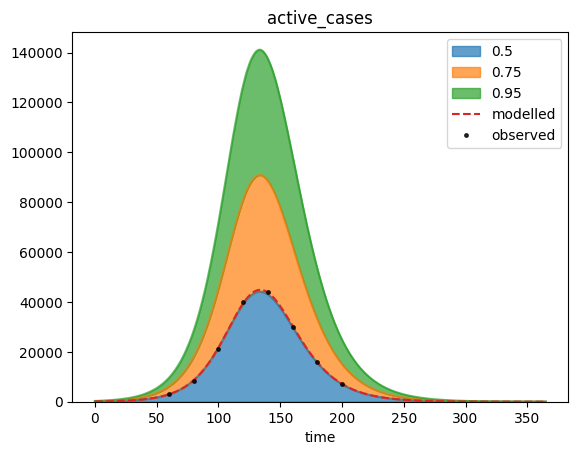

In [92]:
variable = "active_cases"
pd.options.plotting.backend = "matplotlib" #To allow plotly graphic. Swich to "matplotlib" if facing some troubles while ploting

fig = uncertainty_df[variable].plot.area(title=variable,alpha=0.7)
pd.Series(map_res.derived_outputs[variable]).plot(label = "modelled",style='--')
bcm_model_1.targets[variable].data.plot(label = "observed",style='.',color="black", ms=5, alpha=0.8)
plt.legend()